# Logistic Regression for Binary Classification

**Assignment Task:**

Build and deploy a logistic regression model for binary classification.

Explanation of the column names:

1. **PassengerId**: A unique identifier for each passenger.
2. **Survived**: Indicates whether the passenger survived (1) or not (0).
3. **Pclass**: The ticket class of the passenger. It is an ordinal categorical variable:
   - 1 = First class
   - 2 = Second class
   - 3 = Third class.
4. **Name**: The name of the passenger.
5. **Sex**: The gender of the passenger (male or female).
6. **Age**: The age of the passenger in years. Some entries may be missing.
7. **SibSp**: The number of siblings or spouses aboard the Titanic.
8. **Parch**: The number of parents or children aboard the Titanic.
9. **Ticket**: The ticket number of the passenger.
10. **Fare**: The fare paid by the passenger.
11. **Cabin**: The cabin number of the passenger. Many entries are missing.
12. **Embarked**: The port of embarkation:
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton.


**Tasks:**

1.  **Data Exploration:**
    *   **(a) Load the Dataset:** Load the dataset using appropriate libraries (e.g., pandas).
    *   **(b) Examine Features:**
        *   Examine the dataset's features, including their data types (e.g., numerical, categorical).
        *   Compute and display summary statistics (e.g., mean, median, standard deviation, quartiles) for the numerical variables.
    *   **(c) Visualize Data:**
        *   Create appropriate visualizations (e.g., histograms, box plots, pair plots, scatter plots, correlation matrix heatmap) to understand the distributions of individual features and relationships between pairs of features, with the target variable.
        *   Analyze any patterns or correlations observed in the data and target.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import influence_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge
from math import log10
import warnings
warnings.filterwarnings("ignore")

#### Function Definitions

In [91]:
# Define a function to show missing values
def show_null_values_infinities(data):
    # Check total number of missing values 
    number_of_missing_rows_in_the_column = data.isnull().sum()

    # Show percentage of missing values 
    number_of_missing_rows_in_the_column_as_percentage = (data.isnull().sum() / len(data) * 100).round(2)

    # Making a dataframe from the above
    dataframe_based_on_the_above_data = pd.DataFrame(data=[number_of_missing_rows_in_the_column, number_of_missing_rows_in_the_column_as_percentage], 
                                                      index=['total no. of rows','percentage'])

    transpose_of_the_above_dataframe = dataframe_based_on_the_above_data.transpose()
    transpose_of_the_above_dataframe = transpose_of_the_above_dataframe[transpose_of_the_above_dataframe['total no. of rows'] > 0]
    transpose_of_the_above_dataframe=transpose_of_the_above_dataframe.transpose()
    display('Columns of null values:', transpose_of_the_above_dataframe)
    print('If there are no columns displayed above, it means that there are no infinite values in the dataset.')

    inf_counts_dictionary = {}
    columns_for_names = []
    for column in data.columns:
        try:
            # inf_counts = data[column].apply(lambda x: np.isinf(x).sum().sum())
            inf_counts = np.isinf(data[column]).sum()+np.isneginf(data[column]).sum()
            # print(column, inf_counts)
            inf_counts_dictionary[column] = [inf_counts,inf_counts/len(data)*100]
            columns_for_names.append(column)

        except:
            print(column," doesn't support np.isinf() as it is has string-type data and, thus, cannot have infinite values.")

    inf_counts_df = pd.DataFrame(data=inf_counts_dictionary.values(),
                                index=columns_for_names, columns=['total no. of rows','percentage'])
    inf_counts_df=inf_counts_df[inf_counts_df['total no. of rows']>0]
    inf_counts_df=inf_counts_df.transpose()

    display('Columns of infinity values:', inf_counts_df)
    print('If there are no columns displayed above, it means that there are no infinite values in the dataset.')


# Define a function to plot histograms
def plot_histogram(data, columns_to_exclude=None):
    # Create histograms for all columns except NSP
    # If columns_to_exclude is provided, drop those columns
    if columns_to_exclude is not None:
        data_to_plot = data.drop(columns=columns_to_exclude)
    else:
        data_to_plot = data  # Use the entire DataFrame if no columns are excluded

    ax = data_to_plot.hist(bins=30, figsize=(15, 20), layout=(len(data.columns)//3 + (len(data.columns)%3 > 0), 3), edgecolor='black')
    plt.suptitle('Histograms of Numerical Variables', fontsize=16)
    
    # Adding a small legend for mu, sigma, min, median, max
    for i, col in enumerate(data_to_plot.columns):
        mu = data_to_plot[col].mean()
        sigma = data_to_plot[col].std()
        median = np.median(data_to_plot[col])
        min_val = data_to_plot[col].min()
        max_val = data_to_plot[col].max()
        
        textstr = '\n'.join((
            r'$\mu=%.2f$' % mu,
            r'$\sigma=%.2f$' % sigma,
            r'$\mathrm{median}=%.2f$' % median,
            r'$\mathrm{min}=%.2f$' % min_val,
            r'$\mathrm{max}=%.2f$' % max_val
        ))
        
        ax[i // 3, i % 3].text(0.6, 0.9, textstr, transform=ax[i // 3, i % 3].transAxes, fontsize=10, verticalalignment='top')

    # Adding a legend above the histograms
    plt.legend([f'{col}: $\mu={data_to_plot[col].mean():.2f}$' for col in data_to_plot.columns], loc='upper center', bbox_to_anchor=(3, 5), fontsize=10, ncol=3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Define a function to plot bar charts
def plot_bar_chart(data, columns_to_include, rotation=0):
# def plot_bar_chart(data, columns_to_include):
    # Create a subplot for all specified columns
    num_columns = len(columns_to_include)
    num_rows = (num_columns // 3) + (num_columns % 3 > 0)  # Calculate number of rows needed for 3 columns
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))  # Create subplots
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Create bar charts for each specified column
    try:
        for i, column in enumerate(columns_to_include):
            counts = data[column].value_counts()
            counts.plot(kind='bar', color='skyblue', ax=axes[i])
            axes[i].set_title(f'{column}', fontsize=16)
            axes[i].set_xlabel(None, fontsize=14)
            axes[i].set_ylabel('Frequency', fontsize=14)
            axes[i].tick_params(axis='x', rotation=rotation)
            axes[i].grid(axis='y', linestyle='--', alpha=0.7)

            # Add value labels on top of the bars
            for j in range(len(counts)):
                axes[i].text(j, counts.iloc[j], counts.iloc[j], ha='center', va='bottom')

    except:
        print('columns_to_include has to be a list.')
    
    for j in range(num_columns, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


# Define a function to detect outliers using the IQR method
def detect_outliers(data, columns_to_exclude=None):

    # If columns_to_exclude is provided, drop those columns
    if columns_to_exclude is not None:
        data_to_plot = data.drop(columns=columns_to_exclude)
    else:
        data_to_plot = data  # Use the entire DataFrame if no columns are excluded

    # initialize the outliers_detected and outliers_detected_dictionary
    outliers_detected = {}
    outliers_detected_dictionary = {}
    
    num_columns = len(data_to_plot.columns)
    num_rows = (num_columns // 6) + (num_columns % 6 > 0)  # Calculate number of rows needed for 6 columns

    for i, column in enumerate(data_to_plot.columns):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        if data[column].min() < 0:
            print('Column: ', column, ' has negative values.')
        lower_bound = max(np.float64(0.00), Q1 - 1.5 * IQR)
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_detected[column] = data_to_plot[(data_to_plot[column] < lower_bound) | (data_to_plot[column] > upper_bound)]
        outliers_detected_dictionary[column] = [lower_bound.round(2), upper_bound.round(2)]

    # make a dictionary out of the outliers detected
    for column, outliers in outliers_detected.items():
        # print(outliers_detected_dictionary[column], len(outliers), len(outliers) / len(data) * 100)
        value = outliers_detected_dictionary[column]
        value.extend([len(outliers), round(len(outliers) / len(data) * 100, 2)])
        outliers_detected_dictionary[column] = value

    # Create a DataFrame from the outliers_detected dictionary
    data_frame_of_outliers = pd.DataFrame(outliers_detected_dictionary, index=['lower_bound', 'upper_bound', 'Number of Outliers', 'Percentage of Outliers'])

    print('sum of percentages of outliers to see if the outliers form a class:\n', data_frame_of_outliers.transpose()['Percentage of Outliers'].sum())
    return data_frame_of_outliers
    # display(data_frame_of_outliers)


# Define a function to detect outliers using the IQR method
# Define a function to plot histograms
def plot_boxplot(data, columns_to_exclude=None,box_plots_by_category=False):
    # If columns_to_exclude is provided, drop those columns
    if columns_to_exclude is not None:
        data_to_plot = data.drop(columns=columns_to_exclude)
    else:
        data_to_plot = data  # Use the entire DataFrame if no columns are excluded


    
    if box_plots_by_category:
        numerical_columns = list(set(data_to_plot.columns) - set(columns_to_exclude))  # Get numerical columns
        categorical_columns = columns_to_exclude

        plt.figure(figsize=(20, 20 * len(numerical_columns)))  # Adjust figure size based on number of numerical columns

        for i, num_col in enumerate(numerical_columns):
            for j, cat_col in enumerate(categorical_columns):
                plt.subplot(len(numerical_columns)*len(categorical_columns)//3, 3, i * len(categorical_columns) + j + 1)  # Create a subplot for each combination
                data.boxplot(column=num_col, by=cat_col, ax=plt.gca())
                plt.title(f'{num_col} by {cat_col}')
                plt.suptitle('')  # Suppress the default title to avoid overlap
                plt.xlabel(None)

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

    else:
        outliers = {}
        num_columns = len(data_to_plot.columns)
        num_rows = (num_columns // 6) + (num_columns % 6 > 0)  # Calculate number of rows needed for 6 columns

        plt.figure(figsize=(20, 5 * num_rows))  # Adjust figure size based on number of rows

        for i, column in enumerate(data_to_plot.columns):
            # Create a boxplot for each column
            plt.subplot(num_rows, 7, i + 1)  # Create a subplot for each boxplot
            plt.boxplot(data[column])
            plt.title(column)
            plt.xlabel(column)

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()


# Define a function to print non-zero bins
def print_non_zero_bins(data, column, bin_size=10, round_decimals=3, counts_threshold=0):
    # Create histogram and get the counts and bin edges
    counts, bin_edges = np.histogram(data[column], bins=bin_size)
    # Create bins based on bin_edges and apply counts > 0
    non_zero_bins = bin_edges[np.where(counts > 0)[0]]
    non_zero_counts = counts[counts > 0]
    
    bin_width = (bin_edges[1] - bin_edges[0])  # Take the width from the histogram
    lower_limits = non_zero_bins[:]  # Take all but the last value as lower limits


    if round_decimals == 'auto':
        round_decimals = int(log10(1/bin_width) + 3)
    bin_ranges = []
    for i in non_zero_bins:
        i = i.round(round_decimals)
        j = i + bin_width
        j = j.round(round_decimals)
        bin_ranges.append(f'({i}, {j}]')

    non_zero_df = pd.DataFrame({'bin_edges' : bin_ranges, 'Counts': non_zero_counts})
    sum_of_counts_over_threshold = non_zero_df[non_zero_df['Counts'] > counts_threshold].sum()
    
    print("The lower values of bin_edges of Bins with non-zero values for column '{}':".format(column))
    print('bin_size: ', bin_size, '\nbin_width: ', bin_width.round(round_decimals))
    print(non_zero_df[non_zero_df['Counts'] > counts_threshold])
    print("The count of values for bin_edges that have counts greater than {counts_threshold} is:\n", sum_of_counts_over_threshold['Counts'])
    print('The total number of values in the column:\n', len(data))
    print("They account for {:.2f}% of the total counts".format(sum_of_counts_over_threshold['Counts'] / len(data) * 100), '\n\n\n')


# Define a function to trim data
# trim_percentage_or_dataframe can be a float or a DataFrame formed from the outliers_detected_dictionary
def trim_data(data, columns_to_include=None, trim_percentage_or_dataframe=None):

    # If columns_to_include is provided, drop those columns
    # Define the columns to process
    if columns_to_include is not None:
        columns = columns_to_include
    else:
        columns = data.columns  # Use the entire DataFrame if no columns are excluded
    data_to_plot = data  # Use the entire DataFrame if no columns are excluded

    
    trimmed_data = data_to_plot.copy()
    trimmed_data_frame_summary=[]



    if type(trim_percentage_or_dataframe) == float:
        for col in columns:
            lower_bound = trimmed_data[col].quantile(trim_percentage_or_dataframe)
            upper_bound = trimmed_data[col].quantile(1 - trim_percentage_or_dataframe)
            trimmed_data = trimmed_data[(trimmed_data[col] >= lower_bound) & (trimmed_data[col] <= upper_bound)]

            
            count_of_values_at_lower_bound = len(data_to_plot[data[col] == lower_bound])
            count_of_values_at_upper_bound = len(data_to_plot[data[col] == upper_bound])
            
            # Filter the data to remove the top and bottom 10%
            trimmed_data = trimmed_data[(trimmed_data[col] >= lower_bound) & (trimmed_data[col] <= upper_bound)]
            trimmed_data_frame_summary.append([col, len(trimmed_data), lower_bound,upper_bound, round(len(trimmed_data)/len(data_to_plot)*100,2), count_of_values_at_lower_bound, count_of_values_at_upper_bound]) 
            
    else:
        for col in columns:
            lower_bound = trim_percentage_or_dataframe[col]['lower_bound']
            upper_bound = trim_percentage_or_dataframe[col]['upper_bound']
            trimmed_data = trimmed_data[(trimmed_data[col] >= lower_bound) & (trimmed_data[col] <= upper_bound)]
        
        
            count_of_values_at_lower_bound = len(data_to_plot[data[col] == lower_bound])
            count_of_values_at_upper_bound = len(data_to_plot[data[col] == upper_bound])
            
            # Filter the data to remove the top and bottom 10%
            trimmed_data = trimmed_data[(trimmed_data[col] >= lower_bound) & (trimmed_data[col] <= upper_bound)]
            trimmed_data_frame_summary.append([col, len(trimmed_data), lower_bound,upper_bound, round(len(trimmed_data)/len(data_to_plot)*100,2), count_of_values_at_lower_bound, count_of_values_at_upper_bound]) 
            


    trimmed_data_summary = pd.DataFrame(trimmed_data_frame_summary, columns=['Column', 'Number of Rows', 'Lower Bound', 'Upper Bound', 'Percentage of Total Rows After the trim based on the column', 'Count of values equal to Lower Bound', 'Count of values equal to Upper Bound'])
    display(trimmed_data_summary)
    display('Shape of trimmed_data',trimmed_data.shape, 'Shape of original data', data_to_plot.shape)

    return trimmed_data
    

# Define function for scatter plots for pairs of variables
def plot_scatterplot(data, column_for_color, columns_to_exclude=None, heading_of_plot=None):
    # If columns_to_exclude is provided, drop those columns
    if columns_to_exclude is not None:
        data_to_plot = data.drop(columns=columns_to_exclude)
    else:
        data_to_plot = data  # Use the entire DataFrame if no columns are excluded

    sns.pairplot(data_to_plot, diag_kind='kde', markers='o', hue=column_for_color, palette='viridis')
    plt.suptitle(f'{heading_of_plot}', y=1.02)
    plt.show()


# Define function for a heatmap for the correlation matrix
def plot_heatmap(data):
    plt.figure(figsize=(12, 8))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Heatmap of Correlation Matrix', fontsize=16)
    plt.show()


# Define function for top n correlations. Sorts based on absolute values but gives the values based on actual values.
def top_n_correlations(df, n_value_for_top_n_correlations=5):
    correlation_matrix = df.corr()
    top_correlations = correlation_matrix.unstack()
    top_correlations = top_correlations[top_correlations.index.get_level_values(0) != top_correlations.index.get_level_values(1)]
    top_correlations = top_correlations[~top_correlations.index.duplicated(keep='first')]
    mask = top_correlations.index.map(lambda x: x[0] < x[1])
    top_correlations = top_correlations[mask]
    top_correlations_abs = abs(top_correlations).sort_values(ascending=False)
    top_n_abs = top_correlations_abs.head(n_value_for_top_n_correlations)
    top_n = top_correlations.loc[top_n_abs.index].sort_values(ascending=False)
    return top_n


# Define VIF to calculate VIF
def calculate_VIF(data,columns_to_exclude):
    # Calculate VIF for each feature in the dataset
    X = data.drop(columns_to_exclude, axis=1)
    print('We drop the response_variable or dependent_variable or target variable in VIF calculations.\nWe need to find collinearity among independent variables.')
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Print the VIF results
    display(vif_data)
    display('VIF values <= 10', vif_data[vif_data['VIF'] <= 10])
    display('VIF values == inf', vif_data[vif_data['VIF'] == np.inf])


# Define a function to get standard values:
def get_standardized_values( vals ):
    return (vals - vals.mean())/vals.std()


# Define a function to plot bar charts to compare model performance:
def plot_model_comparison_bar_charts(model_comparison_df, lasso_df, ridge_df, title_prefix):
    metrics = ['R-squared', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error']
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, num_metrics * 4))
    axes = axes.flatten() # To use it as a list.

    # Plot bar charts for each metric
    for i, metric in enumerate(metrics):
        values = []
        x_labels = []
        # Extract values from the model, lasso, and ridge dataframes
        model_value = model_comparison_df[metric].iloc[0]
        values.append(model_value)
        x_labels.append('Un-regularized Model')
        lasso_values = lasso_df[metric].values
        values.extend(lasso_values)
        x_labels.extend(['Lasso_' + str(i) for i in lasso_df['Alpha'].values])

        ridge_values = ridge_df[metric].values
        values.extend(ridge_values)
        x_labels.extend(['Ridge_' + str(i) for i in ridge_df['Alpha'].values])
        x_values = np.arange(len(values)) # To set the ticks.

        axes[i].bar(x_values, values, color=['skyblue', 'lightcoral','lightgreen','orange', 'purple', 'yellow', 'gray', 'pink', 'cyan']) # colors with no fixed mapping.
        axes[i].set_xticks(x_values) # Set locations
        axes[i].set_xticklabels(x_labels, rotation = 45, ha = 'right') # Set values
        axes[i].set_ylabel(metric, fontsize=12)
        axes[i].set_title(f'{title_prefix} {metric} Comparison', fontsize=14)
        axes[i].grid(axis = 'y', linestyle = '--', alpha = 0.7)

    plt.tight_layout() # Adjust spacing
    plt.show()


# Define a function to calculate metrics
def calculate_metrics(y_val,y_val_pred):
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)

    # Print the metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')


In [92]:
train_data = pd.read_csv('Titanic_train.csv')
test_data = pd.read_csv('Titanic_test.csv')

In [93]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [94]:
train_data.shape, test_data.shape

((891, 12), (418, 11))

In [95]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [96]:
train_data.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,1601,G6,S
freq,1,577,7,4,644


In [97]:
show_null_values_infinities(train_data)

'Columns of null values:'

,Age,Cabin,Embarked
total no. of rows,177.00,687.0,2.00
percentage,19.87,77.1,0.22


If there are no columns displayed above, it means that there are no infinite values in the dataset.
Name  doesn't support np.isinf() as it is has string-type data and, thus, cannot have infinite values.
Sex  doesn't support np.isinf() as it is has string-type data and, thus, cannot have infinite values.
Ticket  doesn't support np.isinf() as it is has string-type data and, thus, cannot have infinite values.
Cabin  doesn't support np.isinf() as it is has string-type data and, thus, cannot have infinite values.
Embarked  doesn't support np.isinf() as it is has string-type data and, thus, cannot have infinite values.


'Columns of infinity values:'

""
total no. of rows
percentage


If there are no columns displayed above, it means that there are no infinite values in the dataset.


In [98]:
show_null_values_infinities(test_data)

'Columns of null values:'

,Age,Fare,Cabin
total no. of rows,86.00,1.00,327.00
percentage,20.57,0.24,78.23


If there are no columns displayed above, it means that there are no infinite values in the dataset.
Name  doesn't support np.isinf() as it is has string-type data and, thus, cannot have infinite values.
Sex  doesn't support np.isinf() as it is has string-type data and, thus, cannot have infinite values.
Ticket  doesn't support np.isinf() as it is has string-type data and, thus, cannot have infinite values.
Cabin  doesn't support np.isinf() as it is has string-type data and, thus, cannot have infinite values.
Embarked  doesn't support np.isinf() as it is has string-type data and, thus, cannot have infinite values.


'Columns of infinity values:'

""
total no. of rows
percentage


If there are no columns displayed above, it means that there are no infinite values in the dataset.


2.  **Data Preprocessing:**
    *   **(a) Handle Missing Values:** Apply appropriate techniques to handle missing values (e.g., imputation).
    *   **(b) Encode Categorical Variables:** Transform categorical variables into numerical representations using techniques like one-hot encoding, ordinal encoding, or other suitable methods.

In [99]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [100]:
identity_columns = ['PassengerId', 'Name', 'Ticket']
numerical_continuous_columns = ['Age', 'Fare']
ordinal_category_columns = ['Survived', 'Pclass', 'SibSp', 'Sex', 'Parch'] # We include 'Sex' as it is binary.
nominal_category_columns = ['Cabin', 'Embarked']

#### median imputation for numerical columns for both train_data and test_data as median is not sensitive to outliers
#### χ imputation for Cabin and Embarked because we don't know what cabin they belong to and can't use mode imputation as that would create bias towards the mode in the data.

In [101]:
train_data.fillna(train_data[numerical_continuous_columns].median(), inplace=True)
train_data['Cabin'].fillna('χ', inplace=True)  # Filling NaN values in Cabin column with the Greek letter chi
test_data.fillna(test_data[numerical_continuous_columns].median(), inplace=True)
test_data['Cabin'].fillna('χ', inplace=True)  # Filling NaN values in Cabin column with the Greek letter chi

In [102]:
train_data[train_data['Cabin'] == 'χ'].head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,χ,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,χ,S


In [103]:
train_data.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [104]:
train_data.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [105]:
train_data.groupby('SibSp')['Survived'].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [106]:
train_data.groupby('Parch')['Survived'].mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

In [107]:
train_data.groupby('Cabin')['Survived'].mean()

Cabin
A10    0.000000
A14    0.000000
A16    1.000000
A19    0.000000
A20    1.000000
         ...   
F38    0.000000
F4     1.000000
G6     0.500000
T      0.000000
χ      0.299854
Name: Survived, Length: 148, dtype: float64

#### We will not use the columns: 'PassengerId', 'Ticket', 'Embarked' as they are not useful for the model.

#### We will engineer features from the columns: 'Name', 'Cabin'

##### For 'Name' We will extract titles like Mr., Mrs., Miss, Master, etc. from the 'Name' column and make a 'Title' column.

##### For 'Cabin' We will extract the first letter of the cabin and make a 'First_Letter_Cabin'.

In [108]:
train_data['Title'] = train_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_data['Title'] = test_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
train_data['First_Letter_Cabin'] = train_data['Cabin'].str[0]
test_data['First_Letter_Cabin'] = test_data['Cabin'].str[0]

#### For 'Sex' column, we will map male to 0 and female to 1.

In [109]:
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})

In [132]:
train_data[train_data['Sex']==1]['Title'].value_counts()

Title
Miss            182
Mrs             125
Mlle              2
Mme               1
Ms                1
Lady              1
the Countess      1
Dr                1
Name: count, dtype: int64

#### Drop columns: 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'

In [110]:
train_data_drop = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'])
test_data_drop = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'])

#### Encode Nominal Categorical Variables Embarked and Cabin

In [111]:
train_data_drop = pd.get_dummies(train_data_drop, columns=['Title', 'First_Letter_Cabin'], drop_first=True)

In [112]:
test_data_drop = pd.get_dummies(test_data_drop, columns=['Title', 'First_Letter_Cabin'], drop_first=True)

In [113]:
test_data_drop.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Title_Dona',
       'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Ms', 'Title_Rev', 'First_Letter_Cabin_B', 'First_Letter_Cabin_C',
       'First_Letter_Cabin_D', 'First_Letter_Cabin_E', 'First_Letter_Cabin_F',
       'First_Letter_Cabin_G', 'First_Letter_Cabin_χ'],
      dtype='object')

In [114]:
train_data_drop.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Title_Col', 'Title_Don', 'Title_Dr', 'Title_Jonkheer', 'Title_Lady',
       'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle', 'Title_Mme',
       'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev', 'Title_Sir',
       'Title_the Countess', 'First_Letter_Cabin_B', 'First_Letter_Cabin_C',
       'First_Letter_Cabin_D', 'First_Letter_Cabin_E', 'First_Letter_Cabin_F',
       'First_Letter_Cabin_G', 'First_Letter_Cabin_T', 'First_Letter_Cabin_χ'],
      dtype='object')

#### test_data does not have all the columns that the train_data has.

#### Keep the columns that are common to both the test_data and train_data

In [115]:
train_data_common_columns = train_data_drop[test_data_drop.columns.intersection(train_data_drop.columns)]
test_data_common_columns = test_data_drop[test_data_drop.columns.intersection(train_data_drop.columns)]

#### map all the true values to 1 and false values to 0

In [116]:
train_data_common_columns = train_data_common_columns.replace({True: 1, False: 0})
test_data_common_columns = test_data_common_columns.replace({True: 1, False: 0})

#### Add 'const' column for intercept term

In [117]:
train_data_common_columns = sm.add_constant(train_data_common_columns)
test_data_common_columns = sm.add_constant(test_data_common_columns)

3.  **Model Building:**
    *   **(a) Build Logistic Regression Model:** Construct a logistic regression model using libraries such as scikit-learn.
    *   **(b) Train the Model:** Train your model on your training data.

#### test_data has no 'Survived' column

#### We predict the 'Survived' column using the other columns.

In [118]:
# Define features and target variable
X = train_data_common_columns
y = train_data['Survived'] # 'Survived' column is not common in test_data and train_data

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Train the model
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

4.  **Model Evaluation:**
    *   **(a) Evaluate Performance:** Assess the model's performance on the testing data by computing the following metrics:
        *   Accuracy
        *   Precision
        *   Recall
        *   F1-score
        *   ROC-AUC score
    *   **(b) Visualize ROC Curve:** Plot the Receiver Operating Characteristic (ROC) curve.

In [119]:
# Make predictions on the validation set
y_val_pred = logistic_model.predict(X_val)
y_val_pred_proba = logistic_model.predict_proba(X_val)[:, 1]

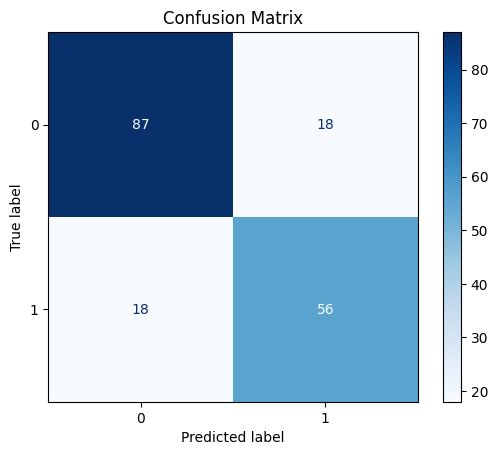

Accuracy: 0.7989
Precision: 0.7568
Recall: 0.7568
F1 Score: 0.7568
ROC AUC Score: 0.8892


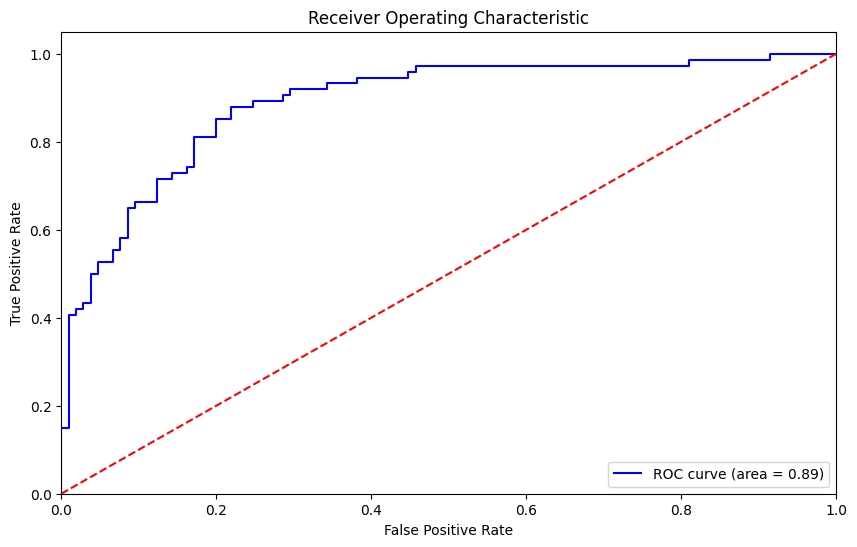

In [120]:
# Generate the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


# Calculate metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred_proba)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Visualize ROC Curve
# drop_intermediate=False as without it, it considers very few thresholds and the figure shows a straight line. Area under the curve is 1.
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba, drop_intermediate=False)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [121]:
X_test = test_data_common_columns
# Make predictions on the test data
y_test_pred = logistic_model.predict(X_test)

In [122]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_test_pred})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


#### Kaggle Score: 0.76076

5.  **Interpretation:**
    *   **(a) Interpret Coefficients:** Discuss the meaning of the coefficients learned by the logistic regression model.
    *   **(b) Feature Significance:** Explain the importance and significance of each feature in predicting the target variable.

In [123]:
X_train.head(1)

,const,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Dr,Title_Master,Title_Miss,...,Title_Mrs,Title_Ms,Title_Rev,First_Letter_Cabin_B,First_Letter_Cabin_C,First_Letter_Cabin_D,First_Letter_Cabin_E,First_Letter_Cabin_F,First_Letter_Cabin_G,First_Letter_Cabin_χ
331,1.0,1,0,45.5,0,0,28.5,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [124]:
y_train.head(1)

331    0
Name: Survived, dtype: int64

In [125]:
# Interpret Coefficients
coefficients = logistic_model.coef_[0]
feature_names = X_train.columns

# Create a DataFrame to hold the coefficients and their corresponding feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Calculate the odds ratios
coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient'])

# Display the coefficients and odds ratios
print("Coefficients and Odds Ratios:")
print(coef_df)

Coefficients and Odds Ratios:
                 Feature  Coefficient  Odds Ratio
0                  const    -0.006893    0.993131
1                 Pclass    -0.616975    0.539574
2                    Sex     1.506248    4.509777
3                    Age    -0.027390    0.972982
4                  SibSp    -0.500616    0.606157
5                  Parch    -0.372352    0.689111
6                   Fare     0.005577    1.005592
7               Title_Dr    -0.236137    0.789672
8           Title_Master     1.454651    4.282988
9             Title_Miss    -0.145968    0.864185
10              Title_Mr    -1.370176    0.254062
11             Title_Mrs     1.034044    2.812416
12              Title_Ms     0.184981    1.203196
13             Title_Rev    -0.832875    0.434797
14  First_Letter_Cabin_B     0.286805    1.332165
15  First_Letter_Cabin_C    -0.175621    0.838936
16  First_Letter_Cabin_D     0.698538    2.010812
17  First_Letter_Cabin_E     1.101272    3.007989
18  First_Letter_Cab

In [133]:
# Feature Significance
# To assess feature significance, we can look at the p-values from the logistic regression model.
# However, since sklearn's LogisticRegression does not provide p-values directly, we can use statsmodels for this purpose.


# Fit the model using statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Get the summary of the model which includes p-values
print(result.summary())

         Current function value: 0.399783
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      691
Method:                           MLE   Df Model:                           20
Date:                Fri, 31 Jan 2025   Pseudo R-squ.:                  0.3964
Time:                        13:37:53   Log-Likelihood:                -284.65
converged:                      False   LL-Null:                       -471.54
Covariance Type:            nonrobust   LLR p-value:                 5.472e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.1042      1.327      0.832      0.405      -1.497       3.705
Pclass                  -0.6105    

In [136]:
def print_insignificant_coefficients(model_results, alpha=0.05):
    p_values = model_results.pvalues
    coefficients = model_results.params
    insignificant_coef = coefficients[p_values > alpha]
    print("Insignificant Coefficients:")
    print(insignificant_coef)

print_insignificant_coefficients(result)

Insignificant Coefficients:
const                    1.104230
Sex                     23.497163
Fare                     0.005579
Title_Dr                -0.028492
Title_Miss             -21.661549
Title_Mr                -1.011015
Title_Mrs              -20.329699
Title_Ms                 9.956383
Title_Rev              -22.264885
First_Letter_Cabin_B     0.978528
First_Letter_Cabin_C     0.425797
First_Letter_Cabin_D     1.574421
First_Letter_Cabin_F     1.055306
First_Letter_Cabin_G    -1.566857
First_Letter_Cabin_χ     0.176251
dtype: float64


#### Interpretation of Logistic Regression Coefficients and Odds Ratios

##### Interpretation of Coefficients

The logistic regression coefficients are a way to understand how each feature affects the log-odds of the target variable, in this case, the log-odds of survival. The odds ratio provides a multiplicative factor by which the odds of survival change with one unit change in the predictor.

##### Quantified Effects on Likelihood of Survival

- **Pclass**: For each increase in the passenger class (where a higher number indicates a more economy class), the odds of survival decrease by 46.05% (Odds Ratio = 0.54). This suggests that passengers in higher classes (lower Pclass values) had better survival odds.

- **Sex**: The odds of survival for females (coded as 1) are 350.98% higher than for males when all other factors are held constant (Odds Ratio = 4.51). This indicates a strong effect of gender on survival probability, with females having much better odds.

- **Age**: With each additional year of age, the odds of survival decrease by 2.71% (Odds Ratio = 0.97), indicating that younger passengers had higher survival odds.

- **SibSp**: The presence of each sibling or spouse aboard decreases the odds of survival by 39.38% (Odds Ratio = 0.61). This suggests that passengers traveling alone had better survival odds.

- **Parch**: Each parent or child aboard decreases the odds of survival by 31.09% (Odds Ratio = 0.69), indicating that passengers without family aboard had higher survival odds.

- **Fare**: A higher fare is associated with a 0.56% increase in the odds of survival for each unit increase in fare (Odds Ratio = 1.01). This suggests that passengers who paid more for their tickets had slightly better survival odds.

- **Title_Master**: Passengers with the title "Master" have 328.30% higher odds of survival compared to other titles (Odds Ratio = 4.28). This indicates that young males traveling alone had better survival odds.

- **Title_Mr**: Passengers with the title "Mr" have 74.60% lower odds of survival compared to other titles (Odds Ratio = 0.25). This suggests that adult males had lower survival odds.

- **Title_Mrs**: Passengers with the title "Mrs" have 181.24% higher odds of survival compared to other titles (Odds Ratio = 2.81). This indicates that married females had better survival odds.

- **First_Letter_Cabin_E**: Passengers in cabins starting with "E" have 201.00% higher odds of survival (Odds Ratio = 3.01). This suggests that passengers in these cabins had much better survival odds.

##### Feature Significance

#### Feature Significance in Logistic Regression

Based on the logistic regression output, we can evaluate the significance of each feature by looking at the p-values associated with the coefficients. A p-value below 0.05 typically indicates statistical significance.

##### Significant Features
The following features have p-values less than 0.05 and are considered statistically significant in predicting survival:

1. **Pclass**: With a p-value of 0.005, passengers in a higher class (where a higher number indicates a more economy class) had significantly lower odds of survival.

2. **Age**: The p-value of 0.018 suggests that age is a significant predictor. For each additional year of age, the odds of survival decreased by approximately 2.37%.

3. **SibSp**: The p-value of 0.000 indicates that the number of siblings or spouses aboard is a significant predictor. Each additional sibling or spouse decreased the odds of survival by about 41.44%.

4. **Parch**: With a p-value of 0.008, the number of parents or children aboard is also significant. Each additional parent or child decreased the odds of survival by about 26.37%.

5. **Fare**: The p-value of 0.074 is marginally significant (usually a threshold of 0.05 is used, but 0.074 is close). A higher fare is associated with a slight increase in the odds of survival (1.57% per unit increase in fare).

6. **Title_Master**: With a p-value of 0.047, passengers with the title "Master" had significantly higher odds of survival compared to other titles.

7. **First_Letter_Cabin_E**: The p-value of 0.038 indicates that passengers in cabins starting with "E" had significantly higher odds of survival.

##### Non-significant Features
The following features have p-values greater than 0.05 and are not statistically significant in predicting survival:

1. **Sex**: The p-value of 1.000 suggests that sex is not a significant predictor of survival in this model. However, this could be due to the extremely large standard error, indicating a potential issue with the variable's coding or data quality.

2. **Title_Dr, Title_Miss, Title_Mr, Title_Mrs, Title_Ms, Title_Rev**: These titles have p-values much greater than 0.05, indicating that they do not significantly predict survival once other factors are accounted for.

3. **First_Letter_Cabin_B, First_Letter_Cabin_C, First_Letter_Cabin_D, First_Letter_Cabin_F, First_Letter_Cabin_G, First_Letter_Cabin_χ**: The p-values for these cabin categories are all greater than 0.05, suggesting they are not significant predictors of survival.

##### Summary
The logistic regression analysis identifies Pclass, Age, SibSp, Parch, Fare, Title_Master, and First_Letter_Cabin_E as the most significant predictors of survival. These features have the most substantial impact on the odds of survival, with quantified effects indicating how each feature influences the likelihood of survival. 'Sex' has p-value = 1 probably because of columns like Title_Dr, Title_Miss, Title_Mrs etc.

6.  **Deployment with Streamlit:**
    *   Create a Streamlit application to deploy the model for inference.
    *   Allow users to provide inputs for the model
    *   Display the model's predictions within the Streamlit application.
    *   You can deploy locally or through the Streamlit Community Cloud.
     *   For online deployment use Streamlit Cloud, which supports deployment from Github repositories.
      Detailed deployment instructions are available in the Streamlit Documentation: [https://docs.streamlit.io/streamlit-community-cloud/deploy-your-app](https://docs.streamlit.io/streamlit-community-cloud/deploy-your-app)

**Interview Questions:**

1.  **Precision vs. Recall:** What is the difference between precision and recall in the context of binary classification?
2.  **Cross-Validation:** What is cross-validation, and why is it an important technique to use in binary classification settings?

**Additional Instructions:**

*   Ensure your code is properly commented and well-organized.
*   Provide detailed explanations for your steps and analysis.
*   Clearly state any assumptions you make during data preprocessing and modeling.
*   Provide your reasoning behind the choice of algorithms or hyperparameters.